In [3]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=e4b83cb0cc30f7b1406d9e75daf1a47de5ed2b2d810d46c37df7d89d9b1a379c
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [4]:
import numpy as np
import pandas as pd
import os
import random
import cv2
import imutils
import random
from sklearn import svm
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Data Loading

In [5]:
dir = "../input/handwritten-characters/Train/"
train_data = []
img_size = 32
non_chars = ["#", "$", "&", "@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir, i)
    for j in os.listdir(sub_directory):
        count += 1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory, j), 0)
        img = cv2.resize(img, (img_size, img_size))
        train_data.append([img, i])
print("Train dataset loaded")

Train dataset loaded


In [6]:
val_dir = "../input/handwritten-characters/Validation/"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir, i)
    for j in os.listdir(sub_directory):
        count += 1
        if count > 1000:
            break
        img = cv2.imread(os.path.join(sub_directory, j), 0)
        img = cv2.resize(img, (img_size, img_size))
        val_data.append([img, i])
print("Validation dataset loaded")

Validation dataset loaded


In [7]:
random.shuffle(train_data)
random.shuffle(val_data)

train_X = []
train_Y = []
for features, label in train_data:
    train_X.append(features)
    train_Y.append(label)

val_X = []
val_Y = []
for features, label in val_data:
    val_X.append(features)
    val_Y.append(label)
    

Train_X = train_X[:]
Train_Y = train_Y[:]
Val_X = val_X[:]
Val_Y = val_Y[:]

In [8]:
# Extract features from images
n_samples = len(train_X)
n_features = img_size * img_size
train_X = np.array(train_X).reshape(n_samples, -1)

n_samples_val = len(val_X)
val_X = np.array(val_X).reshape(n_samples_val, -1)

# Scale the data
n_components = 64  # Adjust the number of components as needed
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(train_X)

train_X = pca.transform(train_X)
val_X = pca.transform(val_X)

# SVM Model

In [227]:
# SVM model
svm_model = svm.SVC(kernel='linear', C=1.0)

# Train the SVM
svm_model.fit(train_X, train_Y)

# Make predictions on the validation set
val_Y_pred = svm_model.predict(val_X)

# Evaluate the SVM model
accuracy = accuracy_score(val_Y, val_Y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 79.76%


In [228]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [229]:
loaded_model = pickle.load(open(filename, 'rb'))

['4']


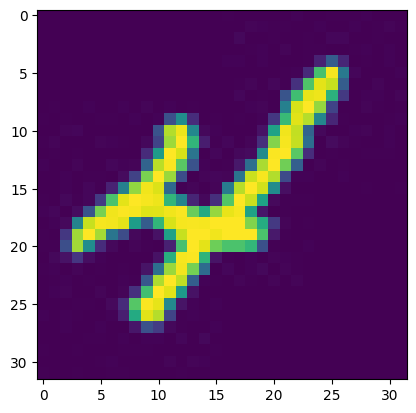

In [230]:
import cv2
import numpy as np

# Load and preprocess the test image
test_image_path = '/kaggle/input/handwritten-characters/Validation/4/0.jpg'
img = cv2.imread(test_image_path, 0)  # Load the image in grayscale
plt.imshow(img)
img = cv2.resize(img, (img_size, img_size))  # Resize to the same dimensions as training data

# Flatten the image into a 1D array
img_flat = img.reshape(-1)

# If necessary, apply the same preprocessing as you did for training data, such as PCA transformation or normalization.
img_transformed = pca.transform([img_flat])  # If you applied PCA transformation

# Make predictions using the SVM model
predn = svm_model.predict(img_transformed)
print(predn)

In [231]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Grapheme Segmentation

In [232]:
import cv2
import imutils
import numpy as np

def grapheme_segmentation(img):
    graphemes = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            roi = gray[y:y + h, x:x + w]
            graphemes.append(roi)
    
    return graphemes, image

In [233]:
def recognize_characters(graphemes, svm_model, pca, img_size):
    letters = []
    
    for roi in graphemes:
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (img_size, img_size), interpolation=cv2.INTER_CUBIC)
        img_flat = thresh.reshape(-1)
        thresh = pca.transform([img_flat])
        ypred = svm_model.predict(thresh)
        letters.append(ypred[0])
    
    return letters

In [315]:
def get_word(letters):
    word = "".join(map(str, letters))
    return word


In [9]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

n_clusters = 40

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(train_X)
nn_model = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(kmeans.cluster_centers_)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [10]:
correct_predictions = 0
total_samples = len(val_X)

for i in range(total_samples):
    nearest_cluster_index = nn_model.kneighbors(val_X, n_neighbors=1)[1][0][0]
    
    predicted_character = train_Y[np.where(kmeans.labels_ == nearest_cluster_index)[0][0]]
    
    if predicted_character == val_Y[i]:
        correct_predictions += 1
accuracy = (correct_predictions / total_samples) * 30
print(f"Accuracy using Nearest Neighbors with K-means: {accuracy*100:.2f}%")

Accuracy using Nearest Neighbors with K-means: 63.52%


# Phase-2

In [235]:
!pip install keras

In [236]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization


In [237]:
LB = LabelBinarizer()
Train_Y = LB.fit_transform(Train_Y)
Val_Y = LB.fit_transform(Val_Y)

In [238]:
print(len(Train_X),len(Val_X))
print(Train_Y.size,Val_Y.size)

140000 15209
4900000 532315


In [239]:
Train_X = np.array(Train_X)/255.0
Train_X = Train_X.reshape(-1,32,32,1)
Train_Y = np.array(Train_Y)

In [240]:
Val_X = np.array(Val_X)/255.0
Val_X = Val_X.reshape(-1,32,32,1)
Val_Y = np.array(Val_Y)

In [241]:
print(Train_X.shape,Val_X.shape)
print(Train_Y.shape,Val_Y.shape)

(140000, 32, 32, 1) (15209, 32, 32, 1)
(140000, 35) (15209, 35)


# Sequential Model-1

In [242]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU

mod1 = Sequential()

mod1.add(Conv2D(64, (3, 3), padding="same", activation='relu', input_shape=(32, 32, 1)))
mod1.add(MaxPooling2D(pool_size=(2, 2)))
mod1.add(Conv2D(64, (3, 3)))
mod1.add(LeakyReLU())
mod1.add(MaxPooling2D(pool_size=(2, 2)))
mod1.add(Conv2D(128, (3, 3)))
mod1.add(LeakyReLU())  
mod1.add(MaxPooling2D(pool_size=(2, 2)))
mod1.add(Dropout(0.25))

mod1.add(Flatten())
mod1.add(Dense(128, activation='relu'))
mod1.add(Dropout(0.2))
mod1.add(Dense(35, activation='softmax'))


In [243]:
mod1.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [244]:
history1 = mod1.fit(Train_X,Train_Y, epochs=20, batch_size=64, validation_data = (Val_X,Val_Y), verbose=1)

Epoch 1/20


2023-12-03 12:18:27.033748: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_134/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2188/2188 [==============================] - 16s 6ms/step - loss: 0.6231 - accuracy: 0.8049 - val_loss: 0.3271 - val_accuracy: 0.8882
Epoch 2/20
2188/2188 [==============================] - 13s 6ms/step - loss: 0.3425 - accuracy: 0.8845 - val_loss: 0.2709 - val_accuracy: 0.9090
Epoch 3/20
2188/2188 [==============================] - 13s 6ms/step - loss: 0.2971 - accuracy: 0.8988 - val_loss: 0.2856 - val_accuracy: 0.8967
Epoch 4/20
2188/2188 [==============================] - 13s 6ms/step - loss: 0.2730 - accuracy: 0.9067 - val_loss: 0.2568 - val_accuracy: 0.9103
Epoch 5/20
2188/2188 [==============================] - 13s 6ms/step - loss: 0.2535 - accuracy: 0.9110 - val_loss: 0.2374 - val_accuracy: 0.9175
Epoch 6/20
2188/2188 [==============================] - 13s 6ms/step - loss: 0.2408 - accuracy: 0.9162 - val_loss: 0.2438 - val_accuracy: 0.9143
Epoch 7/20
2188/2188 [==============================] - 13s 6ms/step - loss: 0.2316 - accuracy: 0.9190 - val_loss: 0.2356 - val_accuracy: 0.9

In [245]:
val_loss, val_accuracy = mod1.evaluate(Val_X, Val_Y)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

476/476 [==============================] - 1s 3ms/step - loss: 0.2263 - accuracy: 0.9277
Validation Accuracy: 92.77%


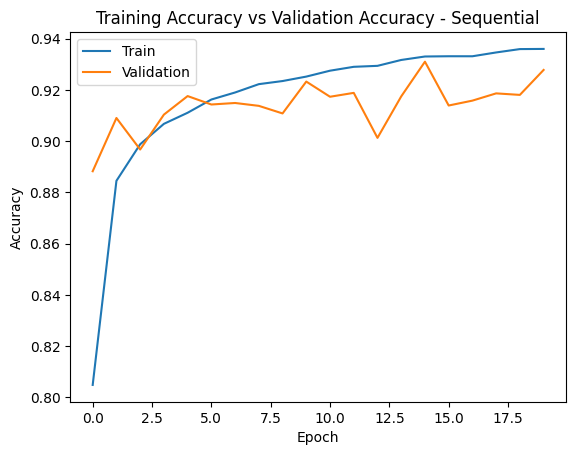

In [246]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy - Sequential')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

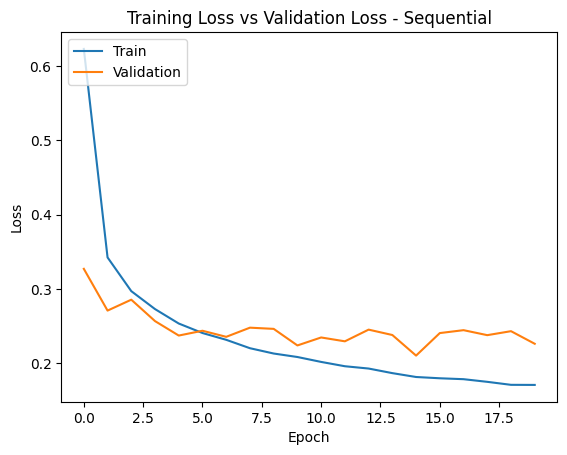

In [247]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Training Loss vs Validation Loss - Sequential')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Sequential-Model2

In [248]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
mod12 = Sequential()

mod12.add(Conv2D(64, (3, 3), padding="same", activation='relu', input_shape=(32, 32, 1)))
mod12.add(MaxPooling2D(pool_size=(2, 2)))
mod12.add(Conv2D(64, (3, 3), activation='relu'))
mod12.add(MaxPooling2D(pool_size=(2, 2)))
mod12.add(Conv2D(128, (3, 3), activation='relu'))
mod12.add(MaxPooling2D(pool_size=(2, 2)))
mod12.add(GlobalAveragePooling2D())
mod12.add(Dense(128, activation='relu'))
mod12.add(Dropout(0.2))
mod12.add(Dense(35, activation='softmax'))

mod12.summary()

Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_264 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d_74 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_265 (Conv2D)         (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_75 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_266 (Conv2D)         (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_76 (MaxPooli  (None, 2, 2, 128)      

In [249]:
mod12.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])
history12 = mod12.fit(Train_X,Train_Y, epochs=20, batch_size=32, validation_data = (Val_X, Val_Y),  verbose=1)

Epoch 1/20
4375/4375 [==============================] - 21s 4ms/step - loss: 0.6946 - accuracy: 0.7800 - val_loss: 0.3296 - val_accuracy: 0.8986
Epoch 2/20
4375/4375 [==============================] - 19s 4ms/step - loss: 0.3485 - accuracy: 0.8834 - val_loss: 0.3336 - val_accuracy: 0.8875
Epoch 3/20
4375/4375 [==============================] - 19s 4ms/step - loss: 0.2932 - accuracy: 0.9000 - val_loss: 0.2698 - val_accuracy: 0.9118
Epoch 4/20
4375/4375 [==============================] - 19s 4ms/step - loss: 0.2632 - accuracy: 0.9092 - val_loss: 0.2613 - val_accuracy: 0.9097
Epoch 5/20
4375/4375 [==============================] - 19s 4ms/step - loss: 0.2426 - accuracy: 0.9154 - val_loss: 0.2738 - val_accuracy: 0.9085
Epoch 6/20
4375/4375 [==============================] - 19s 4ms/step - loss: 0.2271 - accuracy: 0.9198 - val_loss: 0.2661 - val_accuracy: 0.9075
Epoch 7/20
4375/4375 [==============================] - 19s 4ms/step - loss: 0.2149 - accuracy: 0.9222 - val_loss: 0.2328 - val_ac

In [250]:
val_loss, val_accuracy = mod12.evaluate(Val_X, Val_Y)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

476/476 [==============================] - 1s 3ms/step - loss: 0.3176 - accuracy: 0.9026
Validation Accuracy: 90.26%


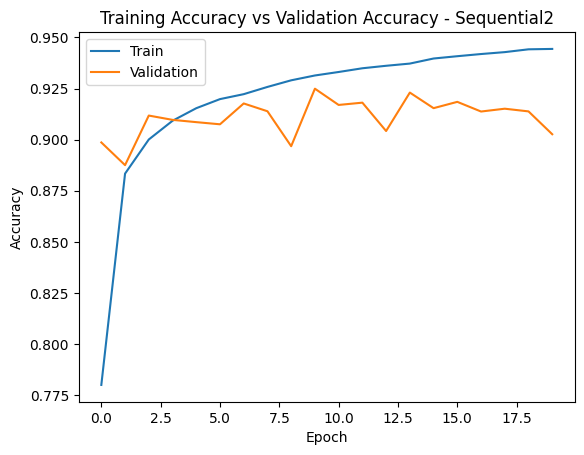

In [251]:
plt.plot(history12.history['accuracy'])
plt.plot(history12.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy - Sequential2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

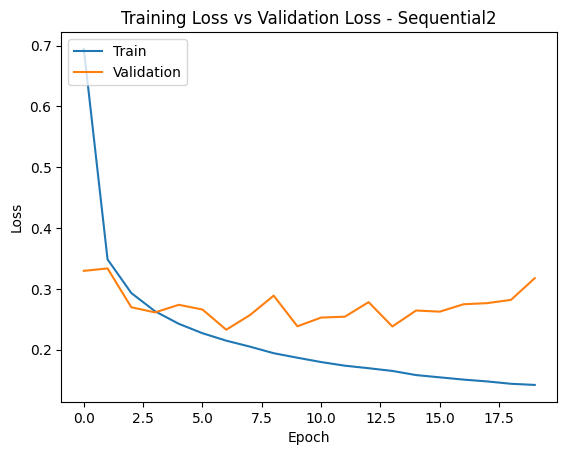

In [252]:
plt.plot(history12.history['loss'])
plt.plot(history12.history['val_loss'])
plt.title('Training Loss vs Validation Loss - Sequential2')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Sequential Model-3

In [253]:
from tensorflow.keras.layers import SpatialDropout2D

mod13 = Sequential()

mod13.add(Conv2D(64, (3, 3), padding="same", activation='relu', input_shape=(32, 32, 1)))
mod13.add(MaxPooling2D(pool_size=(2, 2)))
mod13.add(Conv2D(64, (3, 3), activation='relu'))
mod13.add(MaxPooling2D(pool_size=(2, 2)))
mod13.add(Conv2D(128, (3, 3), activation='relu'))
mod13.add(MaxPooling2D(pool_size=(2, 2)))
mod13.add(SpatialDropout2D(0.25))
mod13.add(Flatten())
mod13.add(Dense(128, activation='relu'))
mod13.add(Dropout(0.2))
mod13.add(Dense(35, activation='softmax'))

mod13.summary()

Model: "sequential_136"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_267 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d_77 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_268 (Conv2D)         (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_78 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_269 (Conv2D)         (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_79 (MaxPooli  (None, 2, 2, 128)      

In [254]:
mod13.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])
history13 = mod13.fit(Train_X,Train_Y, epochs=20, batch_size=32, validation_data = (Val_X,Val_Y),verbose=1)

Epoch 1/20


2023-12-03 12:29:22.246625: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_136/spatial_dropout2d_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4375/4375 [==============================] - 22s 5ms/step - loss: 0.5972 - accuracy: 0.8085 - val_loss: 0.3415 - val_accuracy: 0.8751
Epoch 2/20
4375/4375 [==============================] - 20s 5ms/step - loss: 0.3437 - accuracy: 0.8851 - val_loss: 0.2602 - val_accuracy: 0.9147
Epoch 3/20
4375/4375 [==============================] - 19s 4ms/step - loss: 0.3009 - accuracy: 0.8978 - val_loss: 0.2565 - val_accuracy: 0.9080
Epoch 4/20
4375/4375 [==============================] - 20s 5ms/step - loss: 0.2770 - accuracy: 0.9049 - val_loss: 0.2540 - val_accuracy: 0.9156
Epoch 5/20
4375/4375 [==============================] - 19s 4ms/step - loss: 0.2584 - accuracy: 0.9110 - val_loss: 0.2315 - val_accuracy: 0.9227
Epoch 6/20
4375/4375 [==============================] - 20s 4ms/step - loss: 0.2441 - accuracy: 0.9147 - val_loss: 0.2336 - val_accuracy: 0.9234
Epoch 7/20
4375/4375 [==============================] - 20s 4ms/step - loss: 0.2346 - accuracy: 0.9162 - val_loss: 0.2355 - val_accuracy: 0.9

In [255]:
val_loss, val_accuracy = mod13.evaluate(Val_X, Val_Y)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

476/476 [==============================] - 1s 3ms/step - loss: 0.2472 - accuracy: 0.9214
Validation Accuracy: 92.14%


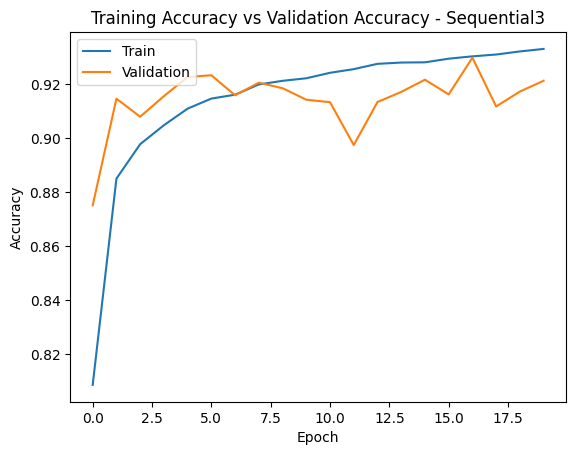

In [256]:
plt.plot(history13.history['accuracy'])
plt.plot(history13.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy - Sequential3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

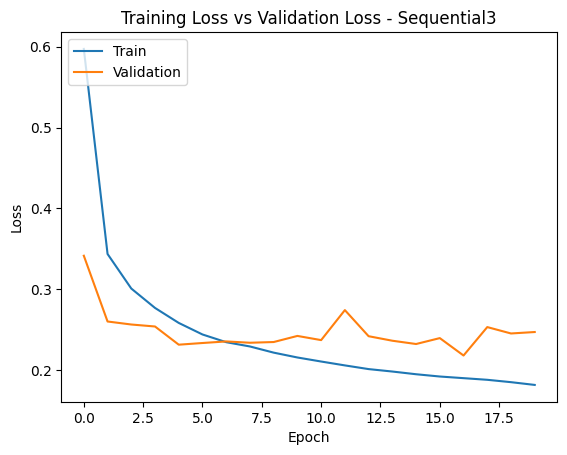

In [257]:
plt.plot(history13.history['loss'])
plt.plot(history13.history['val_loss'])
plt.title('Training Loss vs Validation Loss - Sequential3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Sequential-Model4

In [258]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
mod14 = Sequential()
mod14.add(Conv2D(64, (3, 3), padding="same", activation='relu', input_shape=(32, 32, 1)))
mod14.add(MaxPooling2D(pool_size=(2, 2)))
mod14.add(Conv2D(64, (3, 3), activation='sigmoid'))
mod14.add(MaxPooling2D(pool_size=(2, 2)))
mod14.add(Conv2D(128, (3, 3), activation='tanh'))
mod14.add(MaxPooling2D(pool_size=(2, 2)))
mod14.add(GlobalAveragePooling2D())
mod14.add(Dense(128, activation='relu'))
mod14.add(Dropout(0.2))
mod14.add(Dense(35, activation='softmax'))

mod14.summary()

Model: "sequential_137"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_270 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d_80 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_271 (Conv2D)         (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_81 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_272 (Conv2D)         (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_82 (MaxPooli  (None, 2, 2, 128)      

In [259]:
from keras.optimizers import Adam, SGD, RMSprop, Adadelta
from keras.losses import categorical_crossentropy, mean_squared_error, sparse_categorical_crossentropy, binary_crossentropy

mod14.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
history14 = mod14.fit(Train_X,Train_Y, epochs=20, batch_size=32, validation_data = (Val_X,Val_Y),verbose=1)

Epoch 1/20
4375/4375 [==============================] - 21s 4ms/step - loss: 3.5564 - accuracy: 0.0283 - val_loss: 3.5519 - val_accuracy: 0.0658
Epoch 2/20
4375/4375 [==============================] - 19s 4ms/step - loss: 3.5557 - accuracy: 0.0280 - val_loss: 3.5524 - val_accuracy: 0.0239
Epoch 3/20
4375/4375 [==============================] - 19s 4ms/step - loss: 3.5557 - accuracy: 0.0280 - val_loss: 3.5529 - val_accuracy: 0.0213
Epoch 4/20
4375/4375 [==============================] - 19s 4ms/step - loss: 3.5557 - accuracy: 0.0287 - val_loss: 3.5573 - val_accuracy: 0.0226
Epoch 5/20
4375/4375 [==============================] - 19s 4ms/step - loss: 3.5557 - accuracy: 0.0279 - val_loss: 3.5555 - val_accuracy: 0.0110
Epoch 6/20
4375/4375 [==============================] - 19s 4ms/step - loss: 3.5557 - accuracy: 0.0279 - val_loss: 3.5547 - val_accuracy: 0.0658
Epoch 7/20
4375/4375 [==============================] - 19s 4ms/step - loss: 3.5557 - accuracy: 0.0285 - val_loss: 3.5590 - val_ac

In [260]:
val_loss, val_accuracy = mod14.evaluate(Val_X, Val_Y)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

476/476 [==============================] - 1s 3ms/step - loss: 3.5562 - accuracy: 0.0078
Validation Accuracy: 0.78%


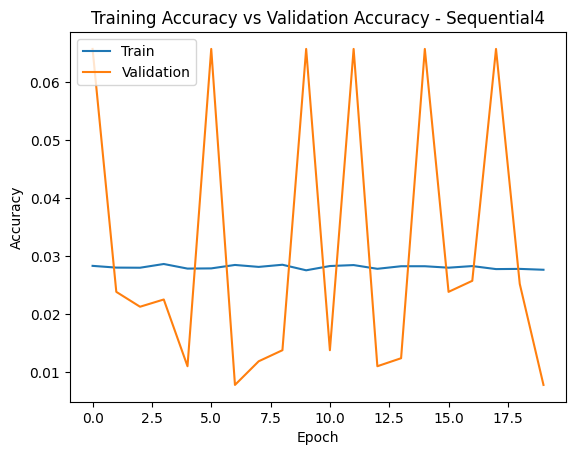

In [261]:
plt.plot(history14.history['accuracy'])
plt.plot(history14.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy - Sequential4')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

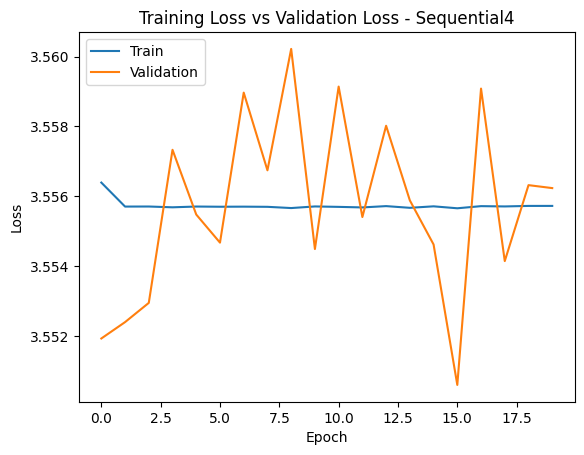

In [262]:
plt.plot(history14.history['loss'])
plt.plot(history14.history['val_loss'])
plt.title('Training Loss vs Validation Loss - Sequential4')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Sequential-Model5

In [263]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

mod15 = Sequential()
mod15.add(Conv2D(32, (3, 3), padding="valid", activation='relu', input_shape=(32, 32, 1)))
mod15.add(MaxPooling2D(pool_size=(2, 2)))
mod15.add(Conv2D(64, (3, 3), activation='relu'))
mod15.add(MaxPooling2D(pool_size=(2, 2)))
mod15.add(Conv2D(128, (3, 3), activation='relu'))  # Change activation function
mod15.add(MaxPooling2D(pool_size=(2, 2)))
mod15.add(GlobalAveragePooling2D())
mod15.add(Dense(128, activation='relu'))
mod15.add(Dropout(0.2))
mod15.add(Dense(35, activation='softmax'))

mod15.summary()


Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_273 (Conv2D)         (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_83 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_274 (Conv2D)         (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_84 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_275 (Conv2D)         (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_85 (MaxPooli  (None, 2, 2, 128)      

In [264]:

from keras.optimizers import Adam, SGD, RMSprop, Adadelta
from keras.losses import categorical_crossentropy, mean_squared_error, sparse_categorical_crossentropy, binary_crossentropy

mod15.compile(loss=categorical_crossentropy, optimizer=SGD(), metrics=['accuracy'])
history15 = mod15.fit(Train_X,Train_Y, epochs=20, batch_size=32, validation_data = (Val_X,Val_Y),verbose=1)

Epoch 1/20
4375/4375 [==============================] - 20s 4ms/step - loss: 2.3780 - accuracy: 0.3366 - val_loss: 0.9339 - val_accuracy: 0.7213
Epoch 2/20
4375/4375 [==============================] - 18s 4ms/step - loss: 0.7469 - accuracy: 0.7643 - val_loss: 0.5443 - val_accuracy: 0.8367
Epoch 3/20
4375/4375 [==============================] - 19s 4ms/step - loss: 0.5461 - accuracy: 0.8238 - val_loss: 0.4607 - val_accuracy: 0.8534
Epoch 4/20
4375/4375 [==============================] - 19s 4ms/step - loss: 0.4674 - accuracy: 0.8478 - val_loss: 0.4280 - val_accuracy: 0.8599
Epoch 5/20
4375/4375 [==============================] - 18s 4ms/step - loss: 0.4216 - accuracy: 0.8619 - val_loss: 0.3648 - val_accuracy: 0.8816
Epoch 6/20
4375/4375 [==============================] - 18s 4ms/step - loss: 0.3924 - accuracy: 0.8700 - val_loss: 0.3698 - val_accuracy: 0.8766
Epoch 7/20
4375/4375 [==============================] - 18s 4ms/step - loss: 0.3688 - accuracy: 0.8775 - val_loss: 0.3444 - val_ac

In [265]:
val_loss, val_accuracy = mod15.evaluate(Val_X, Val_Y)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

476/476 [==============================] - 1s 3ms/step - loss: 0.2775 - accuracy: 0.9065
Validation Accuracy: 90.65%


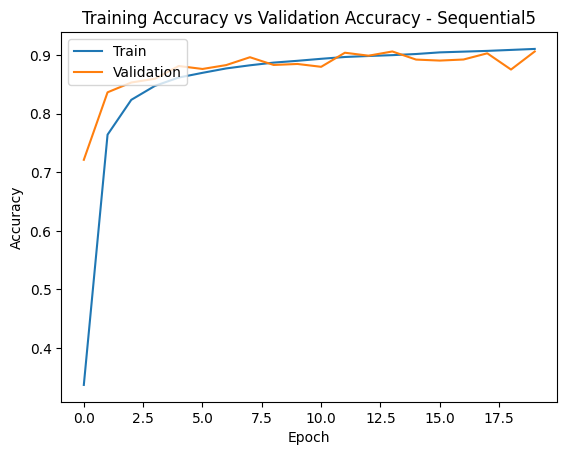

In [266]:
plt.plot(history15.history['accuracy'])
plt.plot(history15.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy - Sequential5')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

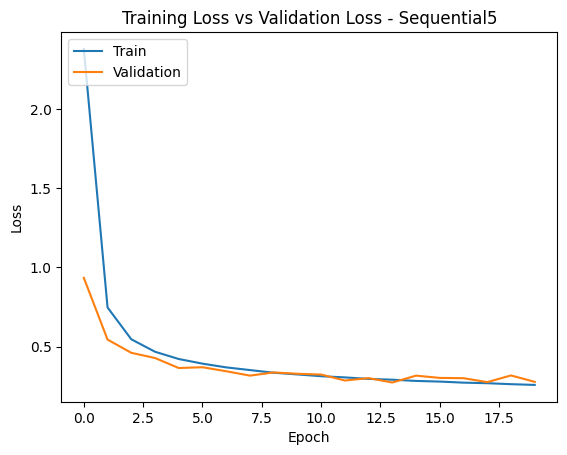

In [267]:
plt.plot(history15.history['loss'])
plt.plot(history15.history['val_loss'])
plt.title('Training Loss vs Validation Loss - Sequential5')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Sequential-Model6

In [268]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout# Model 15
# Model 16
mod16 = Sequential()
mod16.add(Conv2D(64, (3, 3), padding="same", activation='relu', input_shape=(32, 32, 1)))
mod16.add(MaxPooling2D(pool_size=(2, 2)))
mod16.add(Conv2D(64, (3, 3), activation='leaky_relu'))
mod16.add(MaxPooling2D(pool_size=(2, 2)))
mod16.add(Conv2D(128, (3, 3), activation='relu'))
mod16.add(MaxPooling2D(pool_size=(2, 2)))
mod16.add(GlobalAveragePooling2D())
mod16.add(Dense(128, activation='relu'))
mod16.add(Dropout(0.2))
mod16.add(Dense(35, activation='softmax'))

mod16.summary()

Model: "sequential_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_276 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d_86 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_277 (Conv2D)         (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_87 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_278 (Conv2D)         (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_88 (MaxPooli  (None, 2, 2, 128)      

In [269]:

from keras.optimizers import Adam, SGD, RMSprop, Adadelta
from keras.losses import categorical_crossentropy, mean_squared_error, sparse_categorical_crossentropy, binary_crossentropy

# Model 16
mod16.compile(loss=categorical_crossentropy, optimizer=SGD(), metrics=['accuracy'])
history16 = mod16.fit(Train_X,Train_Y, epochs=20, batch_size=32, validation_data = (Val_X,Val_Y),verbose=1)

Epoch 1/20
4375/4375 [==============================] - 19s 4ms/step - loss: 2.3970 - accuracy: 0.3280 - val_loss: 0.9763 - val_accuracy: 0.7152
Epoch 2/20
4375/4375 [==============================] - 18s 4ms/step - loss: 0.7801 - accuracy: 0.7538 - val_loss: 0.5736 - val_accuracy: 0.8207
Epoch 3/20
4375/4375 [==============================] - 18s 4ms/step - loss: 0.5536 - accuracy: 0.8217 - val_loss: 0.4216 - val_accuracy: 0.8712
Epoch 4/20
4375/4375 [==============================] - 18s 4ms/step - loss: 0.4721 - accuracy: 0.8441 - val_loss: 0.4570 - val_accuracy: 0.8453
Epoch 5/20
4375/4375 [==============================] - 18s 4ms/step - loss: 0.4247 - accuracy: 0.8600 - val_loss: 0.3781 - val_accuracy: 0.8799
Epoch 6/20
4375/4375 [==============================] - 18s 4ms/step - loss: 0.3921 - accuracy: 0.8699 - val_loss: 0.4123 - val_accuracy: 0.8452
Epoch 7/20
4375/4375 [==============================] - 18s 4ms/step - loss: 0.3725 - accuracy: 0.8763 - val_loss: 0.3519 - val_ac

In [270]:
val_loss, val_accuracy = mod16.evaluate(Val_X, Val_Y)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

476/476 [==============================] - 1s 3ms/step - loss: 0.2844 - accuracy: 0.9039
Validation Accuracy: 90.39%


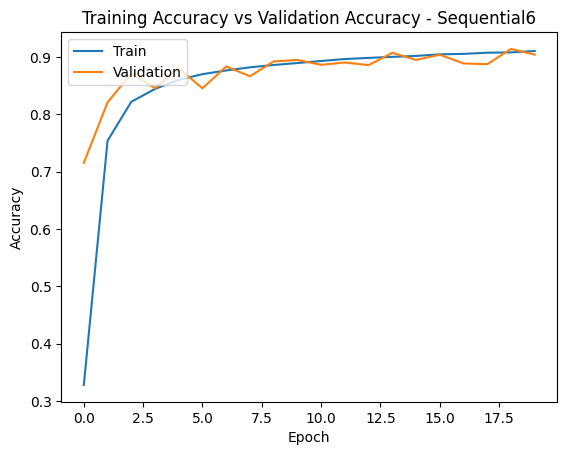

In [271]:
plt.plot(history16.history['accuracy'])
plt.plot(history16.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy - Sequential6')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

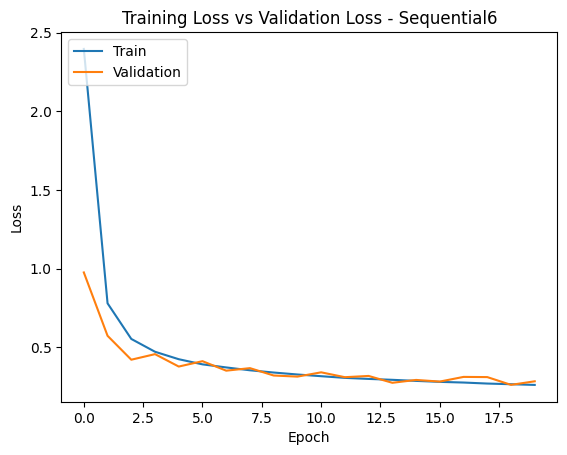

In [272]:
plt.plot(history16.history['loss'])
plt.plot(history16.history['val_loss'])
plt.title('Training Loss vs Validation Loss - Sequential6')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Sequential-Model7

In [273]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

mod17 = Sequential()
mod17.add(Conv2D(32, (3, 3), padding="valid", activation='relu', input_shape=(32, 32, 1)))
mod17.add(MaxPooling2D(pool_size=(2, 2)))
mod17.add(Conv2D(64, (3, 3), activation='elu'))
mod17.add(MaxPooling2D(pool_size=(2, 2)))
mod17.add(Conv2D(128, (3, 3), activation='tanh'))
mod17.add(MaxPooling2D(pool_size=(2, 2)))
mod17.add(Conv2D(128, (3, 3), padding="same", activation='relu'))  # Use padding="same"
mod17.add(MaxPooling2D(pool_size=(2, 2)))

mod17.add(GlobalAveragePooling2D())
mod17.add(Dense(128, activation='relu'))
mod17.add(Dropout(0.2))
mod17.add(Dense(35, activation='softmax'))

mod17.summary()


Model: "sequential_140"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_279 (Conv2D)         (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_89 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_280 (Conv2D)         (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_90 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_281 (Conv2D)         (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_91 (MaxPooli  (None, 2, 2, 128)      

In [274]:
from keras.optimizers import Adadelta
from keras.losses import categorical_crossentropy

# Model 17
mod17.compile(loss=categorical_crossentropy, optimizer=Adadelta(), metrics=['accuracy'])
history17 = mod17.fit(Train_X, Train_Y, epochs=20, batch_size=32, validation_data=(Val_X, Val_Y), verbose=1)


Epoch 1/20
4375/4375 [==============================] - 23s 5ms/step - loss: 3.5467 - accuracy: 0.0543 - val_loss: 3.5305 - val_accuracy: 0.1191
Epoch 2/20
4375/4375 [==============================] - 21s 5ms/step - loss: 3.5276 - accuracy: 0.0829 - val_loss: 3.5055 - val_accuracy: 0.1705
Epoch 3/20
4375/4375 [==============================] - 21s 5ms/step - loss: 3.4926 - accuracy: 0.1149 - val_loss: 3.4517 - val_accuracy: 0.2298
Epoch 4/20
4375/4375 [==============================] - 20s 5ms/step - loss: 3.4193 - accuracy: 0.1504 - val_loss: 3.3395 - val_accuracy: 0.2787
Epoch 5/20
4375/4375 [==============================] - 21s 5ms/step - loss: 3.2835 - accuracy: 0.1851 - val_loss: 3.1571 - val_accuracy: 0.3312
Epoch 6/20
4375/4375 [==============================] - 21s 5ms/step - loss: 3.0954 - accuracy: 0.2244 - val_loss: 2.9401 - val_accuracy: 0.3746
Epoch 7/20
4375/4375 [==============================] - 20s 5ms/step - loss: 2.8967 - accuracy: 0.2612 - val_loss: 2.7352 - val_ac

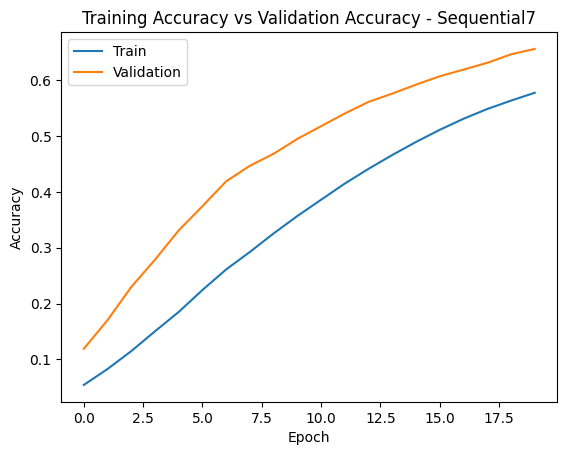

In [275]:
plt.plot(history17.history['accuracy'])
plt.plot(history17.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy - Sequential7')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

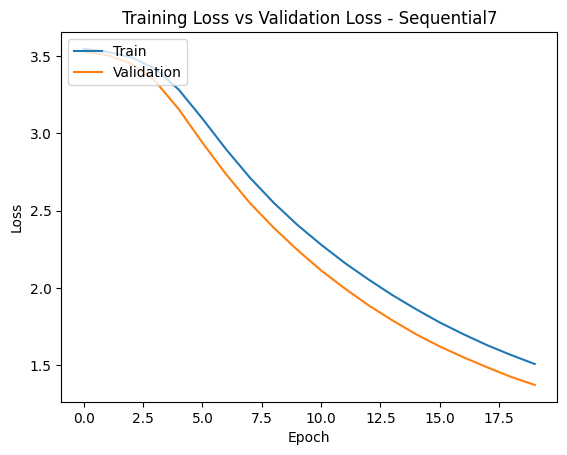

In [276]:
plt.plot(history17.history['loss'])
plt.plot(history17.history['val_loss'])
plt.title('Training Loss vs Validation Loss - Sequential7')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [277]:
val_loss, val_accuracy = mod17.evaluate(Val_X, Val_Y)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

476/476 [==============================] - 1s 3ms/step - loss: 1.3740 - accuracy: 0.6561
Validation Accuracy: 65.61%


# ResNet Model1

In [278]:
import tensorflow as tf
from tensorflow.keras import layers, models

class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(out_channels, kernel_size=3, strides=stride, padding='same', use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv2 = tf.keras.layers.Conv2D(out_channels, kernel_size=3, strides=1, padding='same', use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.shortcut = tf.keras.Sequential()
        if stride != 1:
            self.shortcut.add(tf.keras.layers.Conv2D(out_channels, kernel_size=1, strides=stride, use_bias=False))
            self.shortcut.add(tf.keras.layers.BatchNormalization())

    def call(self, inputs, training=False):
        residual = inputs
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x += self.shortcut(residual)
        x = self.relu(x)
        return x

In [279]:
class ResNetOCR(tf.keras.Model):
    def __init__(self, num_classes=35):
        super(ResNetOCR, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', input_shape=(32, 32, 1), use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')

        self.layer1 = self.make_layer(64, 2, stride=1)
        self.layer2 = self.make_layer(128, 2, stride=2)
        self.layer3 = self.make_layer(256, 2, stride=2)

        self.global_avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def make_layer(self, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, stride=1))
        return tf.keras.Sequential(layers)

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)

        x = self.global_avgpool(x)
        x = self.fc(x)

        return x

In [280]:
train_dataset = tf.data.Dataset.from_tensor_slices((Train_X, Train_Y))
val_dataset = tf.data.Dataset.from_tensor_slices((Val_X, Val_Y))

def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

train_dataset = train_dataset.map(preprocess_image)
val_dataset = val_dataset.map(preprocess_image)

batch_size = 64
train_dataset = train_dataset.shuffle(buffer_size=140000).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

mod2 = ResNetOCR(num_classes=35)

loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

mod2.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [281]:
num_epochs = 20
history2 = mod2.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

mod2.save_weights('resnet_ocr_tf.h5')

Epoch 1/20
2188/2188 [==============================] - 41s 13ms/step - loss: 0.3870 - accuracy: 0.8705 - val_loss: 0.2905 - val_accuracy: 0.9013
Epoch 2/20
2188/2188 [==============================] - 31s 12ms/step - loss: 0.2552 - accuracy: 0.9108 - val_loss: 0.3846 - val_accuracy: 0.8575
Epoch 3/20
2188/2188 [==============================] - 32s 13ms/step - loss: 0.2239 - accuracy: 0.9209 - val_loss: 0.2717 - val_accuracy: 0.9055
Epoch 4/20
2188/2188 [==============================] - 31s 12ms/step - loss: 0.2027 - accuracy: 0.9269 - val_loss: 0.2934 - val_accuracy: 0.9014
Epoch 5/20
2188/2188 [==============================] - 31s 13ms/step - loss: 0.1852 - accuracy: 0.9328 - val_loss: 0.2234 - val_accuracy: 0.9248
Epoch 6/20
2188/2188 [==============================] - 31s 12ms/step - loss: 0.1699 - accuracy: 0.9370 - val_loss: 0.2286 - val_accuracy: 0.9216
Epoch 7/20
2188/2188 [==============================] - 31s 13ms/step - loss: 0.1576 - accuracy: 0.9407 - val_loss: 0.2728 -

In [282]:
val_loss, val_accuracy = mod2.evaluate(Val_X, Val_Y)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

476/476 [==============================] - 2s 4ms/step - loss: 0.3509 - accuracy: 0.9187
Validation Accuracy: 91.87%


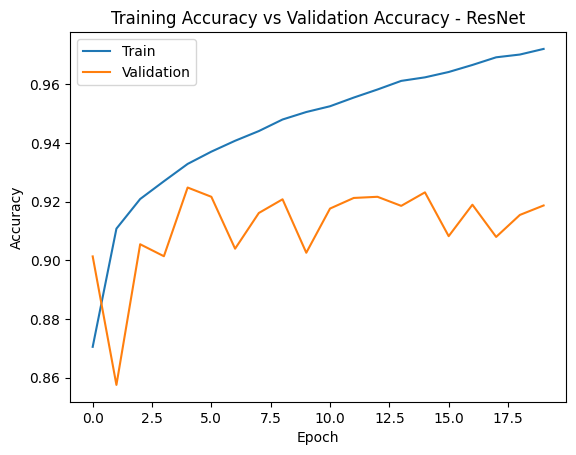

In [283]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy - ResNet')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

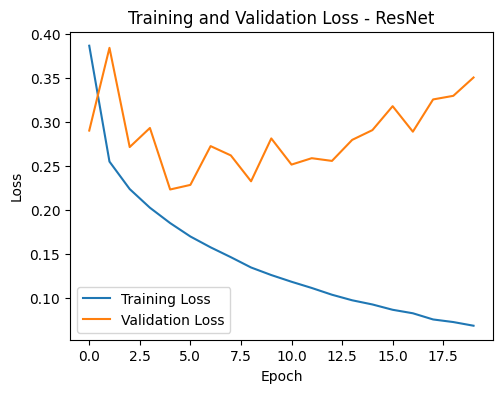

In [284]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - ResNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ResNet Model-2

In [285]:
class ResNetV1(tf.keras.Model):
    def __init__(self, num_classes=35):
        super(ResNetV1, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', input_shape=(32, 32, 1), use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')

        self.layer1 = self.make_layer(64, 2, stride=1)
        self.layer2 = self.make_layer(128, 2, stride=2)
        self.layer3 = self.make_layer(256, 2, stride=2)

        self.global_avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def make_layer(self, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, stride=1))
        return tf.keras.Sequential(layers)

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)

        x = self.global_avgpool(x)
        x = self.fc(x)

        return x

mod22 = ResNetV1(num_classes=35)

loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.0005)

mod22.compile(optimizer=optimizer1, loss=loss_fn, metrics=['accuracy'])


In [286]:
num_epochs = 20
history22 = mod22.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

mod22.save_weights('resnet2_ocr_tf.h5')

Epoch 1/20
2188/2188 [==============================] - 40s 13ms/step - loss: 0.3804 - accuracy: 0.8734 - val_loss: 0.3782 - val_accuracy: 0.8488
Epoch 2/20
2188/2188 [==============================] - 31s 13ms/step - loss: 0.2507 - accuracy: 0.9127 - val_loss: 0.3426 - val_accuracy: 0.8809
Epoch 3/20
2188/2188 [==============================] - 31s 13ms/step - loss: 0.2224 - accuracy: 0.9204 - val_loss: 0.2522 - val_accuracy: 0.9151
Epoch 4/20
2188/2188 [==============================] - 31s 13ms/step - loss: 0.2007 - accuracy: 0.9270 - val_loss: 0.2993 - val_accuracy: 0.8975
Epoch 5/20
2188/2188 [==============================] - 31s 13ms/step - loss: 0.1850 - accuracy: 0.9322 - val_loss: 0.2609 - val_accuracy: 0.9001
Epoch 6/20
2188/2188 [==============================] - 31s 13ms/step - loss: 0.1701 - accuracy: 0.9369 - val_loss: 0.2383 - val_accuracy: 0.9176
Epoch 7/20
2188/2188 [==============================] - 31s 13ms/step - loss: 0.1598 - accuracy: 0.9401 - val_loss: 0.2246 -

In [287]:
val_loss, val_accuracy = mod22.evaluate(Val_X, Val_Y)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

476/476 [==============================] - 2s 4ms/step - loss: 0.3055 - accuracy: 0.9189
Validation Accuracy: 91.89%


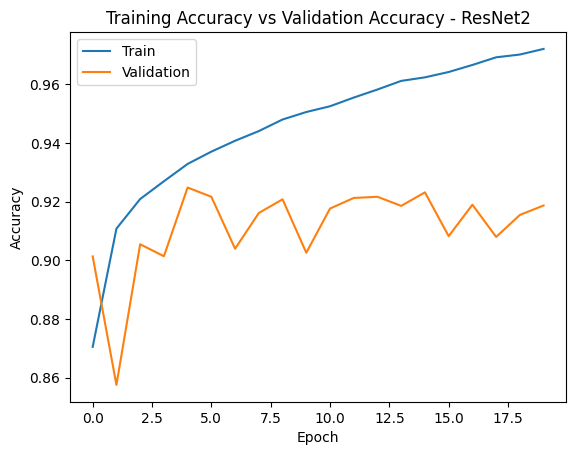

In [288]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy - ResNet2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

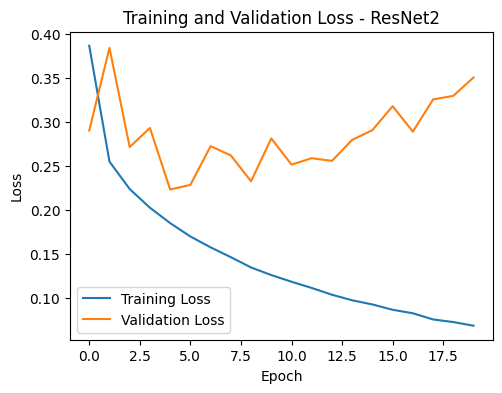

In [289]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - ResNet2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ResNet-Model3

In [290]:
class ResNetV2(tf.keras.Model):
    def __init__(self, num_classes=35):
        super(ResNetV2, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', input_shape=(32, 32, 1), use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')

        self.layer1 = self.make_layer(64, 3, stride=1)  # Increased the number of blocks
        self.layer2 = self.make_layer(128, 4, stride=2)  # Increased the number of blocks
        self.layer3 = self.make_layer(256, 6, stride=2)  # Increased the number of blocks

        self.global_avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def make_layer(self, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, stride=1))
        return tf.keras.Sequential(layers)

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)

        x = self.global_avgpool(x)
        x = self.fc(x)

        return x

# Using a higher learning rate for Variation 2
mod3 = ResNetV2(num_classes=35)

loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.002)

mod3.compile(optimizer=optimizer2, loss=loss_fn, metrics=['accuracy'])

In [291]:
num_epochs = 20
history23 = mod3.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

mod3.save_weights('resnet3_ocr_tf.h5')

Epoch 1/20
2188/2188 [==============================] - 69s 23ms/step - loss: 0.4540 - accuracy: 0.8528 - val_loss: 0.3528 - val_accuracy: 0.8887
Epoch 2/20
2188/2188 [==============================] - 52s 22ms/step - loss: 0.2769 - accuracy: 0.9058 - val_loss: 0.3009 - val_accuracy: 0.9093
Epoch 3/20
2188/2188 [==============================] - 53s 22ms/step - loss: 0.2369 - accuracy: 0.9165 - val_loss: 0.2980 - val_accuracy: 0.8998
Epoch 4/20
2188/2188 [==============================] - 53s 23ms/step - loss: 0.2147 - accuracy: 0.9234 - val_loss: 0.2673 - val_accuracy: 0.9029
Epoch 5/20
2188/2188 [==============================] - 52s 22ms/step - loss: 0.1960 - accuracy: 0.9288 - val_loss: 0.2733 - val_accuracy: 0.9095
Epoch 6/20
2188/2188 [==============================] - 53s 22ms/step - loss: 0.1797 - accuracy: 0.9339 - val_loss: 0.2353 - val_accuracy: 0.9178
Epoch 7/20
2188/2188 [==============================] - 52s 22ms/step - loss: 0.1646 - accuracy: 0.9387 - val_loss: 0.2519 -

In [292]:
val_loss, val_accuracy = mod3.evaluate(Val_X, Val_Y)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

476/476 [==============================] - 3s 7ms/step - loss: 0.3080 - accuracy: 0.9233
Validation Accuracy: 92.33%


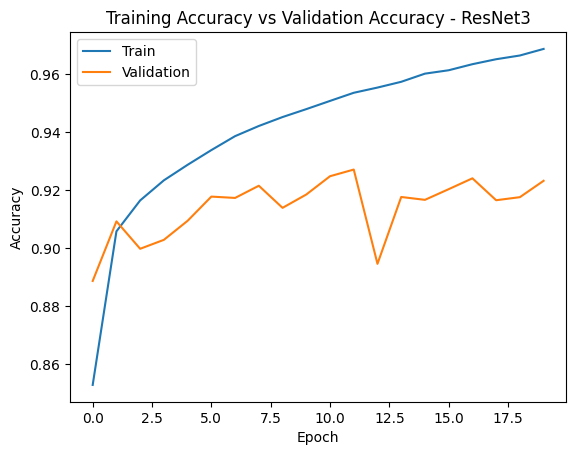

In [293]:
plt.plot(history23.history['accuracy'])
plt.plot(history23.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy - ResNet3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

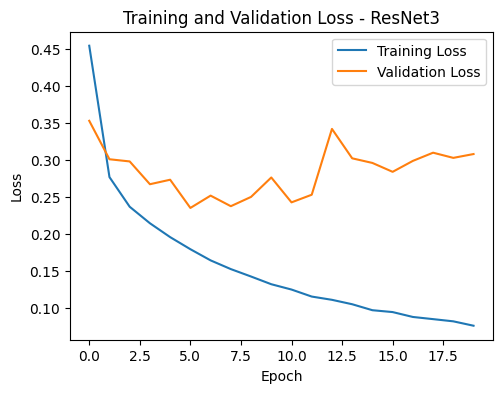

In [294]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 2)
plt.plot(history23.history['loss'], label='Training Loss')
plt.plot(history23.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - ResNet3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# C-RNN

In [295]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
num_classes=35

class CRNN(tf.keras.Model):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()

        self.conv1 = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')
        self.conv2 = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')
        self.pooling = layers.MaxPooling2D(pool_size=(2, 2))

        self.rnn = layers.LSTM(128, return_sequences=True)

        self.flatten = layers.Flatten()
        
        self.fc1 = layers.Dense(256, activation='relu')
        self.fc2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.pooling(x)
        x = self.conv2(x)
        x = self.pooling(x)
        
        # Reshape for LSTM
        x = tf.transpose(x, [0, 2, 1, 3])  # Swap dimensions
        x = tf.reshape(x, [-1, x.shape[1], x.shape[2] * x.shape[3]])

        # Apply LSTM
        x = self.rnn(x)

        x = self.flatten(x)
        x = self.fc1(x)
        output = self.fc2(x)

        return output

# Build and compile the model
crnn_model = CRNN(num_classes)
crnn_model.build((None, 32, 32, 1))  # Input shape
crnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
crnn_model.summary()


Model: "crnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_342 (Conv2D)         multiple                  640       
                                                                 
 conv2d_343 (Conv2D)         multiple                  73856     
                                                                 
 max_pooling2d_96 (MaxPooli  multiple                  0         
 ng2D)                                                           
                                                                 
 lstm_1 (LSTM)               multiple                  590336    
                                                                 
 flatten_8 (Flatten)         multiple                  0         
                                                                 
 dense_61 (Dense)            multiple                  262400    
                                                            

In [296]:
epochs = 10
batch_size = 64

history_crnn = crnn_model.fit(
    Train_X, Train_Y,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(Val_X, Val_Y)
)

Epoch 1/10
2188/2188 [==============================] - 19s 7ms/step - loss: 0.4482 - accuracy: 0.8541 - val_loss: 0.2576 - val_accuracy: 0.9145
Epoch 2/10
2188/2188 [==============================] - 15s 7ms/step - loss: 0.2438 - accuracy: 0.9142 - val_loss: 0.2521 - val_accuracy: 0.9149
Epoch 3/10
2188/2188 [==============================] - 15s 7ms/step - loss: 0.2029 - accuracy: 0.9262 - val_loss: 0.2379 - val_accuracy: 0.9172
Epoch 4/10
2188/2188 [==============================] - 15s 7ms/step - loss: 0.1753 - accuracy: 0.9349 - val_loss: 0.2473 - val_accuracy: 0.9106
Epoch 5/10
2188/2188 [==============================] - 15s 7ms/step - loss: 0.1545 - accuracy: 0.9410 - val_loss: 0.2570 - val_accuracy: 0.9193
Epoch 6/10
2188/2188 [==============================] - 15s 7ms/step - loss: 0.1373 - accuracy: 0.9461 - val_loss: 0.2675 - val_accuracy: 0.9023
Epoch 7/10
2188/2188 [==============================] - 15s 7ms/step - loss: 0.1233 - accuracy: 0.9511 - val_loss: 0.2876 - val_ac

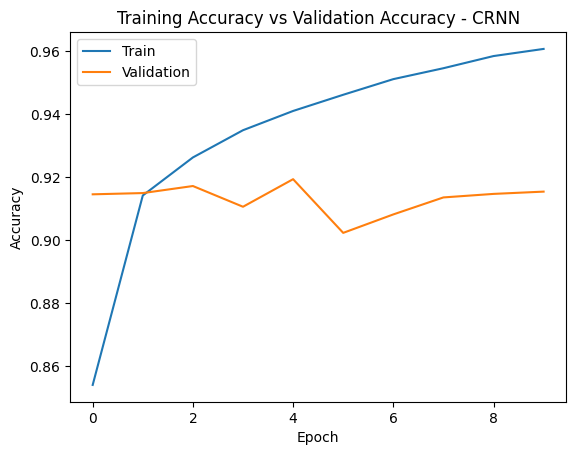

In [297]:
plt.plot(history_crnn.history['accuracy'])
plt.plot(history_crnn.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy - CRNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

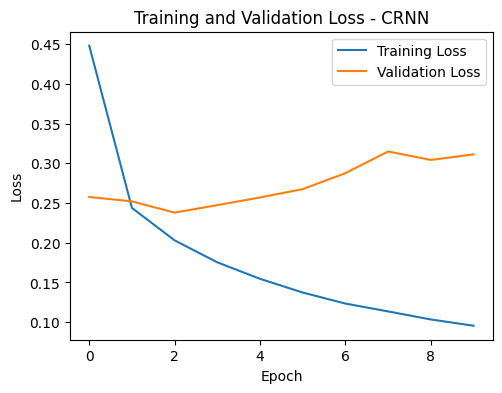

In [298]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 2)
plt.plot(history_crnn.history['loss'], label='Training Loss')
plt.plot(history_crnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - CRNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [299]:
val_loss, val_accuracy = crnn_model.evaluate(Val_X, Val_Y)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

476/476 [==============================] - 2s 3ms/step - loss: 0.3113 - accuracy: 0.9154
Validation Accuracy: 91.54%


In [353]:
model_s = [mod2,mod1,mod3]
img = "../input/sank4gy/WhatsApp Image 2023-12-03 at 8.28.35 PM.jpeg"

1/1 [==============================] - 0s 20ms/step
SANK
1/1 [==============================] - 0s 25ms/step
SANK


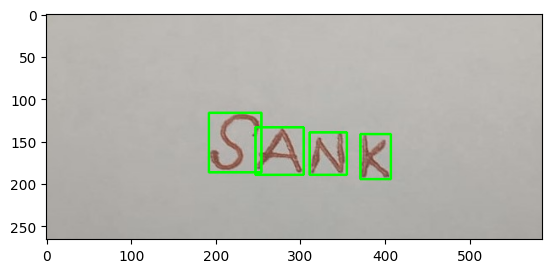

In [354]:
letter,image = get_letters(img,mod1)
word = get_word(letter)
print(word)
plt.imshow(image)

letter,image =  ensemble_soft_voting(img,model_s,LB)
word = get_word(letter)
print(word)
plt.imshow(image)



In [347]:
def get_letters(img,mod):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]

    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = mod.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
        
    return letters, image

In [348]:
def ensemble_soft_voting(img, models, label_binarizer):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]

    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            roi = gray[y:y + h, x:x + w]

            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            thresh = cv2.resize(thresh, (32, 32), interpolation=cv2.INTER_CUBIC)
            thresh = thresh.astype("float32") / 255.0
            thresh = np.expand_dims(thresh, axis=-1)
            thresh = thresh.reshape(1, 32, 32, 1)

            # Collect class probabilities from each model
            probabilities = [model.predict(thresh) for model in models]

            # Perform soft voting
            ensemble_prediction = np.mean(probabilities, axis=0)
            predicted_label = label_binarizer.inverse_transform(ensemble_prediction.reshape(1, -1))[0]

            letters.append(predicted_label)

    return letters, image
